In [1]:
!pip install gensim
!pip install keras


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences 
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping



In [4]:
# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

In [5]:
# Word2vec
import gensim

In [6]:
# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

In [30]:
# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [31]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tuchek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
# DATASET
DATASET_COLUMNS = ["date_posted", "hour_played", "recommendation", "text", "title", "target"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

# READ DATA SET

In [33]:
#Read in the clean_steam_reviews CSV
steam_df = pd.read_csv(os.path.join("clean_steam_reviews.csv"))
steam_df.head(10)

,Unnamed: 0,date_posted,hour_played,recommendation,text,title,target
0,0,2019-02-10,578,Recommended,&gt Played as German Reich&gt Declare war on B...,Expansion - Hearts of Iron IV: Man the Guns,1
1,1,2019-02-10,184,Recommended,yes.,Expansion - Hearts of Iron IV: Man the Guns,1
2,2,2019-02-07,892,Recommended,Very good game although a bit overpriced in my...,Expansion - Hearts of Iron IV: Man the Guns,1
3,3,2018-06-14,676,Recommended,Out of all the reviews I wrote This one is pro...,Dead by Daylight,1
4,4,2017-06-20,612,Recommended,Disclaimer I survivor main. I play games for f...,Dead by Daylight,1
5,5,2016-12-12,2694,Recommended,ENGLISH After playing for more than two years ...,Dead by Daylight,1
6,6,2017-09-17,48,Recommended,Out of all the reviews I wrote This one is pro...,Dead by Daylight,1
7,7,2018-12-24,71,Recommended,I have never been told to kill myself more tha...,Dead by Daylight,1
8,8,2018-09-21,400,Recommended,Any longtime Dead by Daylight player knows tha...,Dead by Daylight,1
9,9,2018-12-05,414,Recommended,if you think cs go is toxic try this game,Dead by Daylight,1


In [34]:
# dataset_filename = os.listdir("clean_steam_reviews")[0]
# dataset_path = os.path.join("input",dataset_filename)
# print("Open file:", dataset_path)
# df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [35]:
print("Dataset size:", len(steam_df))

Dataset size: 433375


In [36]:
steam_df.head(5)

,Unnamed: 0,date_posted,hour_played,recommendation,text,title,target
0,0,2019-02-10,578,Recommended,&gt Played as German Reich&gt Declare war on B...,Expansion - Hearts of Iron IV: Man the Guns,1
1,1,2019-02-10,184,Recommended,yes.,Expansion - Hearts of Iron IV: Man the Guns,1
2,2,2019-02-07,892,Recommended,Very good game although a bit overpriced in my...,Expansion - Hearts of Iron IV: Man the Guns,1
3,3,2018-06-14,676,Recommended,Out of all the reviews I wrote This one is pro...,Dead by Daylight,1
4,4,2017-06-20,612,Recommended,Disclaimer I survivor main. I play games for f...,Dead by Daylight,1


# Map Target Label to String

In [37]:
decode_map = {0: "NOT RECOMMENDED", 1: "RECOMMENDED"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [38]:
%%time
steam_df.target = steam_df.target.apply(lambda x: decode_sentiment(x))

Wall time: 305 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

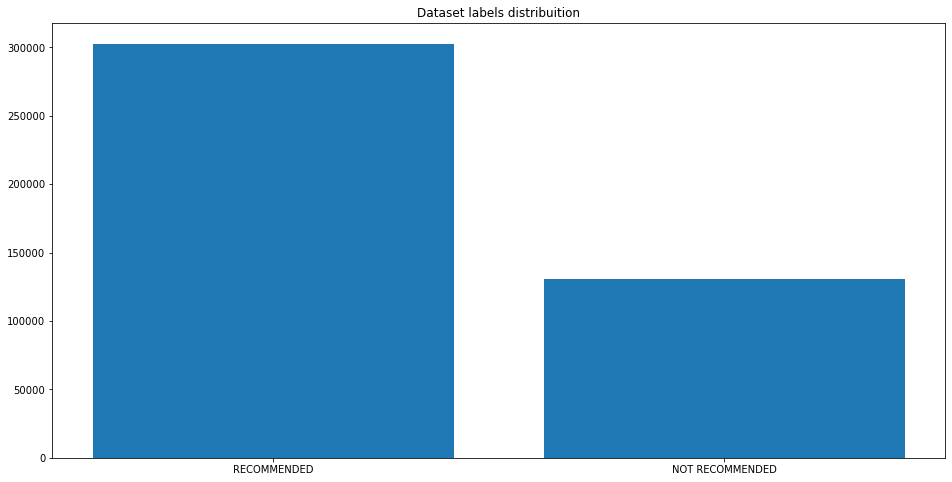

In [39]:
target_cnt = Counter(steam_df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

# Pre Process Data Set

In [40]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [41]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

# Split and Train Test

In [42]:
df_train, df_test = train_test_split(steam_df, test_size=1-TRAIN_SIZE, random_state=50)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 346700
TEST size: 86675


In [43]:
%%time
documents = [_text.split() for _text in df_train.text] 

Wall time: 4.08 s


# Word2Vec

In [44]:
%%time
documents = [_text.split() for _text in df_train.text] 

Wall time: 17 s


In [45]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [46]:
w2v_model.build_vocab(documents)

2021-03-10 19:55:18,701 : INFO : collecting all words and their counts
2021-03-10 19:55:18,704 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-03-10 19:55:19,074 : INFO : PROGRESS: at sentence #10000, processed 409048 words, keeping 37138 word types
2021-03-10 19:55:19,305 : INFO : PROGRESS: at sentence #20000, processed 816953 words, keeping 59490 word types
2021-03-10 19:55:19,531 : INFO : PROGRESS: at sentence #30000, processed 1223397 words, keeping 79233 word types
2021-03-10 19:55:19,850 : INFO : PROGRESS: at sentence #40000, processed 1623652 words, keeping 96975 word types
2021-03-10 19:55:20,312 : INFO : PROGRESS: at sentence #50000, processed 2036715 words, keeping 114105 word types
2021-03-10 19:55:20,624 : INFO : PROGRESS: at sentence #60000, processed 2433827 words, keeping 129383 word types
2021-03-10 19:55:21,002 : INFO : PROGRESS: at sentence #70000, processed 2834735 words, keeping 143938 word types
2021-03-10 19:55:21,235 : INFO : PROGR

In [47]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 31485


In [48]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2021-03-10 19:56:04,344 : INFO : training model with 8 workers on 31485 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2021-03-10 19:56:05,536 : INFO : EPOCH 1 - PROGRESS: at 3.38% examples, 321606 words/s, in_qsize 15, out_qsize 1
2021-03-10 19:56:06,570 : INFO : EPOCH 1 - PROGRESS: at 6.78% examples, 332829 words/s, in_qsize 14, out_qsize 1
2021-03-10 19:56:07,615 : INFO : EPOCH 1 - PROGRESS: at 10.01% examples, 328806 words/s, in_qsize 15, out_qsize 0
2021-03-10 19:56:08,702 : INFO : EPOCH 1 - PROGRESS: at 13.13% examples, 321415 words/s, in_qsize 15, out_qsize 0
2021-03-10 19:56:09,704 : INFO : EPOCH 1 - PROGRESS: at 16.35% examples, 322520 words/s, in_qsize 16, out_qsize 1
2021-03-10 19:56:10,737 : INFO : EPOCH 1 - PROGRESS: at 20.49% examples, 336677 words/s, in_qsize 15, out_qsize 0
2021-03-10 19:56:11,749 : INFO : EPOCH 1 - PROGRESS: at 23.93% examples, 339262 words/s, in_qsize 15, out_qsize 0
2021-03-10 19:56:12,773 : INFO : EPOCH 1 - PROGRESS: a

2021-03-10 19:57:11,898 : INFO : EPOCH 2 - PROGRESS: at 80.58% examples, 295934 words/s, in_qsize 15, out_qsize 0
2021-03-10 19:57:12,961 : INFO : EPOCH 2 - PROGRESS: at 84.47% examples, 299276 words/s, in_qsize 16, out_qsize 0
2021-03-10 19:57:13,993 : INFO : EPOCH 2 - PROGRESS: at 88.10% examples, 301600 words/s, in_qsize 16, out_qsize 1
2021-03-10 19:57:15,051 : INFO : EPOCH 2 - PROGRESS: at 91.89% examples, 304040 words/s, in_qsize 14, out_qsize 5
2021-03-10 19:57:16,082 : INFO : EPOCH 2 - PROGRESS: at 95.70% examples, 306613 words/s, in_qsize 15, out_qsize 0
2021-03-10 19:57:17,120 : INFO : EPOCH 2 - PROGRESS: at 99.55% examples, 308876 words/s, in_qsize 7, out_qsize 1
2021-03-10 19:57:17,122 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-03-10 19:57:17,133 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-03-10 19:57:17,135 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-03-10 19:57:17,168 : INFO : worker thre

2021-03-10 19:58:06,746 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-03-10 19:58:06,770 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-03-10 19:58:06,784 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-03-10 19:58:06,798 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-03-10 19:58:06,801 : INFO : EPOCH - 4 : training on 14059602 raw words (10359243 effective words) took 23.7s, 437180 effective words/s
2021-03-10 19:58:07,835 : INFO : EPOCH 5 - PROGRESS: at 4.16% examples, 430461 words/s, in_qsize 16, out_qsize 2
2021-03-10 19:58:08,841 : INFO : EPOCH 5 - PROGRESS: at 8.84% examples, 457980 words/s, in_qsize 15, out_qsize 0
2021-03-10 19:58:09,844 : INFO : EPOCH 5 - PROGRESS: at 13.10% examples, 452177 words/s, in_qsize 15, out_qsize 0
2021-03-10 19:58:10,862 : INFO : EPOCH 5 - PROGRESS: at 17.65% examples, 453476 words/s, in_qsize 15, out_qsize 0
2021-03-10 19:58:11,876 : INFO : EPOCH 5 -

2021-03-10 19:59:02,071 : INFO : EPOCH 7 - PROGRESS: at 33.40% examples, 419635 words/s, in_qsize 15, out_qsize 1
2021-03-10 19:59:03,073 : INFO : EPOCH 7 - PROGRESS: at 37.69% examples, 421371 words/s, in_qsize 16, out_qsize 1
2021-03-10 19:59:04,106 : INFO : EPOCH 7 - PROGRESS: at 41.85% examples, 421675 words/s, in_qsize 15, out_qsize 0
2021-03-10 19:59:05,113 : INFO : EPOCH 7 - PROGRESS: at 45.80% examples, 420681 words/s, in_qsize 11, out_qsize 4
2021-03-10 19:59:06,169 : INFO : EPOCH 7 - PROGRESS: at 50.19% examples, 421223 words/s, in_qsize 15, out_qsize 0
2021-03-10 19:59:07,213 : INFO : EPOCH 7 - PROGRESS: at 54.76% examples, 423100 words/s, in_qsize 11, out_qsize 3
2021-03-10 19:59:08,216 : INFO : EPOCH 7 - PROGRESS: at 58.93% examples, 424071 words/s, in_qsize 15, out_qsize 0
2021-03-10 19:59:09,261 : INFO : EPOCH 7 - PROGRESS: at 63.38% examples, 425134 words/s, in_qsize 15, out_qsize 0
2021-03-10 19:59:10,262 : INFO : EPOCH 7 - PROGRESS: at 67.76% examples, 426812 words/s,

2021-03-10 20:00:01,511 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-03-10 20:00:01,514 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-03-10 20:00:01,525 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-03-10 20:00:01,551 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-03-10 20:00:01,554 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-03-10 20:00:01,581 : INFO : EPOCH 9 - PROGRESS: at 99.87% examples, 462720 words/s, in_qsize 2, out_qsize 1
2021-03-10 20:00:01,583 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-03-10 20:00:01,585 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-03-10 20:00:01,603 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-03-10 20:00:01,605 : INFO : EPOCH - 9 : training on 14059602 raw words (10363078 effective words) took 22.4s, 462866 effective words/s
2021-03-10 20:00:02

2021-03-10 20:00:53,381 : INFO : EPOCH 12 - PROGRESS: at 18.97% examples, 381615 words/s, in_qsize 16, out_qsize 1
2021-03-10 20:00:54,390 : INFO : EPOCH 12 - PROGRESS: at 23.65% examples, 397558 words/s, in_qsize 15, out_qsize 0
2021-03-10 20:00:55,420 : INFO : EPOCH 12 - PROGRESS: at 28.68% examples, 410930 words/s, in_qsize 15, out_qsize 0
2021-03-10 20:00:56,450 : INFO : EPOCH 12 - PROGRESS: at 33.85% examples, 423511 words/s, in_qsize 15, out_qsize 0
2021-03-10 20:00:57,451 : INFO : EPOCH 12 - PROGRESS: at 38.41% examples, 428093 words/s, in_qsize 14, out_qsize 1
2021-03-10 20:00:58,463 : INFO : EPOCH 12 - PROGRESS: at 43.25% examples, 435702 words/s, in_qsize 15, out_qsize 0
2021-03-10 20:00:59,477 : INFO : EPOCH 12 - PROGRESS: at 47.87% examples, 439043 words/s, in_qsize 15, out_qsize 0
2021-03-10 20:01:00,489 : INFO : EPOCH 12 - PROGRESS: at 52.70% examples, 443661 words/s, in_qsize 15, out_qsize 0
2021-03-10 20:01:01,498 : INFO : EPOCH 12 - PROGRESS: at 57.37% examples, 446199

2021-03-10 20:01:52,535 : INFO : EPOCH 14 - PROGRESS: at 90.74% examples, 461244 words/s, in_qsize 14, out_qsize 1
2021-03-10 20:01:53,566 : INFO : EPOCH 14 - PROGRESS: at 94.99% examples, 460064 words/s, in_qsize 14, out_qsize 1
2021-03-10 20:01:54,593 : INFO : EPOCH 14 - PROGRESS: at 99.06% examples, 457537 words/s, in_qsize 12, out_qsize 2
2021-03-10 20:01:54,704 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-03-10 20:01:54,712 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-03-10 20:01:54,720 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-03-10 20:01:54,742 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-03-10 20:01:54,752 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-03-10 20:01:54,755 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-03-10 20:01:54,775 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-03-10 20:01:5

2021-03-10 20:02:44,103 : INFO : EPOCH 17 - PROGRESS: at 4.45% examples, 451214 words/s, in_qsize 15, out_qsize 0
2021-03-10 20:02:45,109 : INFO : EPOCH 17 - PROGRESS: at 9.18% examples, 470879 words/s, in_qsize 15, out_qsize 0
2021-03-10 20:02:46,114 : INFO : EPOCH 17 - PROGRESS: at 13.84% examples, 475324 words/s, in_qsize 15, out_qsize 0
2021-03-10 20:02:47,143 : INFO : EPOCH 17 - PROGRESS: at 18.72% examples, 476710 words/s, in_qsize 15, out_qsize 0
2021-03-10 20:02:48,144 : INFO : EPOCH 17 - PROGRESS: at 23.38% examples, 477631 words/s, in_qsize 15, out_qsize 0
2021-03-10 20:02:49,148 : INFO : EPOCH 17 - PROGRESS: at 28.78% examples, 488039 words/s, in_qsize 15, out_qsize 0
2021-03-10 20:02:50,172 : INFO : EPOCH 17 - PROGRESS: at 33.40% examples, 484597 words/s, in_qsize 15, out_qsize 0
2021-03-10 20:02:51,211 : INFO : EPOCH 17 - PROGRESS: at 38.41% examples, 485306 words/s, in_qsize 15, out_qsize 0
2021-03-10 20:02:52,232 : INFO : EPOCH 17 - PROGRESS: at 43.24% examples, 486940 w

2021-03-10 20:03:43,093 : INFO : EPOCH 19 - PROGRESS: at 40.94% examples, 375410 words/s, in_qsize 14, out_qsize 1
2021-03-10 20:03:44,142 : INFO : EPOCH 19 - PROGRESS: at 45.53% examples, 382446 words/s, in_qsize 15, out_qsize 0
2021-03-10 20:03:45,189 : INFO : EPOCH 19 - PROGRESS: at 50.46% examples, 390588 words/s, in_qsize 14, out_qsize 1
2021-03-10 20:03:46,210 : INFO : EPOCH 19 - PROGRESS: at 55.33% examples, 397246 words/s, in_qsize 12, out_qsize 3
2021-03-10 20:03:47,217 : INFO : EPOCH 19 - PROGRESS: at 59.78% examples, 401596 words/s, in_qsize 14, out_qsize 1
2021-03-10 20:03:48,221 : INFO : EPOCH 19 - PROGRESS: at 64.20% examples, 404586 words/s, in_qsize 15, out_qsize 0
2021-03-10 20:03:49,244 : INFO : EPOCH 19 - PROGRESS: at 68.02% examples, 403812 words/s, in_qsize 15, out_qsize 0
2021-03-10 20:03:50,257 : INFO : EPOCH 19 - PROGRESS: at 72.05% examples, 404127 words/s, in_qsize 14, out_qsize 1
2021-03-10 20:03:51,284 : INFO : EPOCH 19 - PROGRESS: at 76.67% examples, 408170

2021-03-10 20:04:41,778 : INFO : EPOCH 21 - PROGRESS: at 95.29% examples, 462863 words/s, in_qsize 15, out_qsize 0
2021-03-10 20:04:42,696 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-03-10 20:04:42,703 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-03-10 20:04:42,705 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-03-10 20:04:42,710 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-03-10 20:04:42,712 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-03-10 20:04:42,722 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-03-10 20:04:42,724 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-03-10 20:04:42,746 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-03-10 20:04:42,749 : INFO : EPOCH - 21 : training on 14059602 raw words (10362551 effective words) took 22.3s, 464485 effective words/s
2021-03-10 20:04

2021-03-10 20:05:33,343 : INFO : EPOCH 24 - PROGRESS: at 29.54% examples, 427662 words/s, in_qsize 15, out_qsize 0
2021-03-10 20:05:34,358 : INFO : EPOCH 24 - PROGRESS: at 33.23% examples, 421107 words/s, in_qsize 13, out_qsize 2
2021-03-10 20:05:35,374 : INFO : EPOCH 24 - PROGRESS: at 36.68% examples, 412535 words/s, in_qsize 15, out_qsize 0
2021-03-10 20:05:36,393 : INFO : EPOCH 24 - PROGRESS: at 40.11% examples, 406348 words/s, in_qsize 15, out_qsize 0
2021-03-10 20:05:37,403 : INFO : EPOCH 24 - PROGRESS: at 44.37% examples, 409440 words/s, in_qsize 16, out_qsize 0
2021-03-10 20:05:38,425 : INFO : EPOCH 24 - PROGRESS: at 48.14% examples, 407220 words/s, in_qsize 15, out_qsize 0
2021-03-10 20:05:39,443 : INFO : EPOCH 24 - PROGRESS: at 52.43% examples, 409410 words/s, in_qsize 15, out_qsize 0
2021-03-10 20:05:40,479 : INFO : EPOCH 24 - PROGRESS: at 57.38% examples, 415412 words/s, in_qsize 15, out_qsize 0
2021-03-10 20:05:41,487 : INFO : EPOCH 24 - PROGRESS: at 62.14% examples, 420007

2021-03-10 20:06:32,818 : INFO : EPOCH 26 - PROGRESS: at 94.70% examples, 482582 words/s, in_qsize 16, out_qsize 0
2021-03-10 20:06:33,825 : INFO : EPOCH 26 - PROGRESS: at 99.07% examples, 480630 words/s, in_qsize 14, out_qsize 0
2021-03-10 20:06:33,937 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-03-10 20:06:33,947 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-03-10 20:06:33,951 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-03-10 20:06:33,956 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-03-10 20:06:33,973 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-03-10 20:06:33,992 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-03-10 20:06:34,010 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-03-10 20:06:34,020 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-03-10 20:06:34,023 : INFO : EPOCH - 2

2021-03-10 20:07:23,777 : INFO : EPOCH - 28 : training on 14059602 raw words (10363672 effective words) took 26.8s, 386879 effective words/s
2021-03-10 20:07:24,882 : INFO : EPOCH 29 - PROGRESS: at 3.51% examples, 356007 words/s, in_qsize 13, out_qsize 2
2021-03-10 20:07:25,897 : INFO : EPOCH 29 - PROGRESS: at 7.64% examples, 389264 words/s, in_qsize 14, out_qsize 1
2021-03-10 20:07:26,922 : INFO : EPOCH 29 - PROGRESS: at 11.19% examples, 380008 words/s, in_qsize 15, out_qsize 0
2021-03-10 20:07:27,989 : INFO : EPOCH 29 - PROGRESS: at 15.43% examples, 387469 words/s, in_qsize 15, out_qsize 0
2021-03-10 20:07:28,991 : INFO : EPOCH 29 - PROGRESS: at 19.25% examples, 388378 words/s, in_qsize 16, out_qsize 0
2021-03-10 20:07:30,055 : INFO : EPOCH 29 - PROGRESS: at 23.09% examples, 385321 words/s, in_qsize 16, out_qsize 0
2021-03-10 20:07:31,077 : INFO : EPOCH 29 - PROGRESS: at 27.64% examples, 394705 words/s, in_qsize 15, out_qsize 0
2021-03-10 20:07:32,079 : INFO : EPOCH 29 - PROGRESS: at

2021-03-10 20:08:22,499 : INFO : EPOCH 31 - PROGRESS: at 46.54% examples, 421523 words/s, in_qsize 14, out_qsize 1
2021-03-10 20:08:23,514 : INFO : EPOCH 31 - PROGRESS: at 49.88% examples, 414680 words/s, in_qsize 15, out_qsize 0
2021-03-10 20:08:24,523 : INFO : EPOCH 31 - PROGRESS: at 52.85% examples, 406213 words/s, in_qsize 15, out_qsize 0
2021-03-10 20:08:25,548 : INFO : EPOCH 31 - PROGRESS: at 57.12% examples, 407682 words/s, in_qsize 14, out_qsize 1
2021-03-10 20:08:26,555 : INFO : EPOCH 31 - PROGRESS: at 60.82% examples, 406184 words/s, in_qsize 15, out_qsize 0
2021-03-10 20:08:27,556 : INFO : EPOCH 31 - PROGRESS: at 64.70% examples, 405374 words/s, in_qsize 15, out_qsize 0
2021-03-10 20:08:28,566 : INFO : EPOCH 31 - PROGRESS: at 68.09% examples, 402303 words/s, in_qsize 15, out_qsize 0
2021-03-10 20:08:29,603 : INFO : EPOCH 31 - PROGRESS: at 71.69% examples, 399819 words/s, in_qsize 15, out_qsize 0
2021-03-10 20:08:30,629 : INFO : EPOCH 31 - PROGRESS: at 75.37% examples, 398944

Wall time: 12min 55s


(331581497, 449907264)

In [49]:
w2v_model.most_similar("love")

<ipython-input-49-9e1a4c826e7b>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  w2v_model.most_similar("love")
2021-03-10 20:10:56,326 : INFO : precomputing L2-norms of word weight vectors


[('hate', 0.6895469427108765),
 ('loved', 0.6539959907531738),
 ('Love', 0.647836446762085),
 ('enjoy', 0.6455405950546265),
 ('adore', 0.6207034587860107),
 ('liked', 0.5966242551803589),
 ('LOVE', 0.5744820237159729),
 ('luv', 0.5582122206687927),
 ('dislike', 0.5541728138923645),
 ('recommend', 0.49958938360214233)]

In [50]:
w2v_model.most_similar("fun")

<ipython-input-50-e02d7be84874>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  w2v_model.most_similar("fun")


[('fun.', 0.7155592441558838),
 ('enjoyable', 0.7085375785827637),
 ('fun!', 0.6636222004890442),
 ('blast', 0.600725531578064),
 ('entertaining', 0.5938655138015747),
 ('funny', 0.5668469667434692),
 ('great', 0.5536203980445862),
 ('fun...', 0.5397957563400269),
 ('frustrating', 0.534489631652832),
 ('good', 0.5339673757553101)]

In [51]:
w2v_model.most_similar("exciting")

<ipython-input-51-b91d4aefd334>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  w2v_model.most_similar("exciting")


[('entertaining', 0.6466375589370728),
 ('intense', 0.6354601979255676),
 ('interesting', 0.622502326965332),
 ('enjoyable', 0.6048544645309448),
 ('tense', 0.5993873476982117),
 ('thrilling', 0.5907541513442993),
 ('engaging', 0.5801414251327515),
 ('addictive', 0.5733288526535034),
 ('challenging', 0.5697798728942871),
 ('immersive', 0.5535655617713928)]

In [52]:
w2v_model.most_similar("sucks")

<ipython-input-52-eaa207e9ba15>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  w2v_model.most_similar("sucks")


[('sucks.', 0.6131856441497803),
 ('suck', 0.49332424998283386),
 ('sux', 0.4406989514827728),
 ('hurts', 0.42914992570877075),
 ('sucks...', 0.4034218192100525),
 ('ruins', 0.4007611870765686),
 ('awfull', 0.38044464588165283),
 ('terrible', 0.35983389616012573),
 ('suck.', 0.35844871401786804),
 ('shity', 0.35815370082855225)]

# Tokenize Text

In [53]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 196286
Wall time: 28.9 s


In [54]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

Wall time: 48.6 s


# Label Encoder

In [56]:
labels = df_train.target.unique().tolist()
# labels.append(NEUTRAL)
labels

['RECOMMENDED', 'NOT RECOMMENDED']

In [57]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (346700, 1)
y_test (86675, 1)


In [58]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (346700, 300)
y_train (346700, 1)

x_test (86675, 300)
y_test (86675, 1)


In [59]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=int64)

# Embedding Layer

In [60]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(196286, 300)


In [61]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

# Build Model

In [62]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          58885800  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 59,046,301
Trainable params: 160,501
Non-trainable params: 58,885,800
_________________________________________________________________


# Compile Model

In [63]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

# Callbacks

In [64]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

# Train

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
305/305 [==============================] - 8497s 28s/step - loss: 0.4534 - accuracy: 0.7788 - val_loss: 0.3187 - val_accuracy: 0.8626


2021-03-10 22:44:42,850 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


Epoch 2/8
 80/305 [======>.......................] - ETA: 1:36:25 - loss: 0.3304 - accuracy: 0.8552

# Evaluate

In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

# Plot

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

# Predict

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NOT RECOMMEND
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = RECOMMEND

        return label
    else:
        return NOT RECOMMEND if score < 0.5 else RECOMMEND

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [ ]:
predict("I love the music")

In [ ]:
predict("I hate the rain")

In [ ]:
predict("i don't know what i'm doing")

# Confusiuon Matrix

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [ ]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

# Classification Report

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

# Accuracy Score

In [ ]:
accuracy_score(y_test_1d, y_pred_1d)

# Save Model

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)